In [1]:
!nvidia-smi

Tue Sep 24 12:25:53 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:4E:00.0 Off |                    0 |
| N/A   31C    P0    64W / 400W |      0MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/alexanderiw/Nathan Stuff/Sentimen Analisis BTC/Predict


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import csv


# Baca data dari CSV
df = pd.read_csv('Data/price.csv')

# Pastikan kolom 'price' ada
if 'price' not in df.columns:
    raise ValueError("Kolom 'price' tidak ditemukan dalam file CSV")

# Ambil kolom 'price' saja
prices = df['price'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Fungsi untuk membuat sekuens
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Buat sekuens
seq_length = 24*7*4
X, y = create_sequences(scaled_prices, seq_length)

# Bagi data menjadi train dan test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [4]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.metrics = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        accuracy = 1 - np.mean(np.abs((y_val - y_pred) / y_val))
        
        self.metrics.append({
            'epoch': epoch + 1,
            'rmse': rmse,
            'mae': mae,
            'accuracy': accuracy
        })

# Bangun model BiLSTM
model = Sequential([
    Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(seq_length, 1)),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Buat callback
metrics_callback = MetricsCallback((X_test, y_test))

# Latih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[metrics_callback])

# Simpan hasil ke CSV
with open('training_results_per_epoch.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['epoch', 'rmse', 'mae', 'accuracy'])
    writer.writeheader()
    writer.writerows(metrics_callback.metrics)

print("Hasil pelatihan per epoch telah disimpan di 'training_results_per_epoch.csv'")

2024-09-24 12:26:15.227259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 12:26:15.820875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79135 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


Epoch 1/10


2024-09-24 12:26:20.653290: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39/39 [==============================] - 70s 2s/step - loss: 0.0894 - mae: 0.2065 - val_loss: 0.0048 - val_mae: 0.0544
Epoch 2/10
39/39 [==============================] - 73s 2s/step - loss: 0.0034 - mae: 0.0449 - val_loss: 0.0027 - val_mae: 0.0428
Epoch 3/10
39/39 [==============================] - 82s 2s/step - loss: 0.0025 - mae: 0.0364 - val_loss: 0.0021 - val_mae: 0.0381
Epoch 4/10
39/39 [==============================] - 79s 2s/step - loss: 0.0020 - mae: 0.0319 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 5/10
39/39 [==============================] - 75s 2s/step - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 6/10
39/39 [==============================] - 79s 2s/step - loss: 0.0015 - mae: 0.0283 - val_loss: 0.0010 - val_mae: 0.0241
Epoch 7/10
39/39 [==============================] - 81s 2s/step - loss: 0.0013 - mae: 0.0256 - val_loss: 8.6197e-04 - val_mae: 0.0219
Epoch 8/10
39/39 [==============================] - 82s 2s/step - loss: 0.0012 - mae: 0.0246 - va

In [5]:
# Prediksi
y_pred = model.predict(X_test)

# Hitung metrik akhir
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
accuracy = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

# Simpan hasil akhir ke CSV
results_df = pd.DataFrame({
    'RMSE': [rmse],
    'MAE': [mae],
    'Accuracy': [accuracy]
})
results_df.to_csv('final_training_results.csv', index=False)

print("Hasil akhir pelatihan:")
print(results_df)


10/10 [==============================] - 6s 555ms/step
Hasil akhir pelatihan:
       RMSE       MAE  Accuracy
0  0.029042  0.021928  0.925159


plot

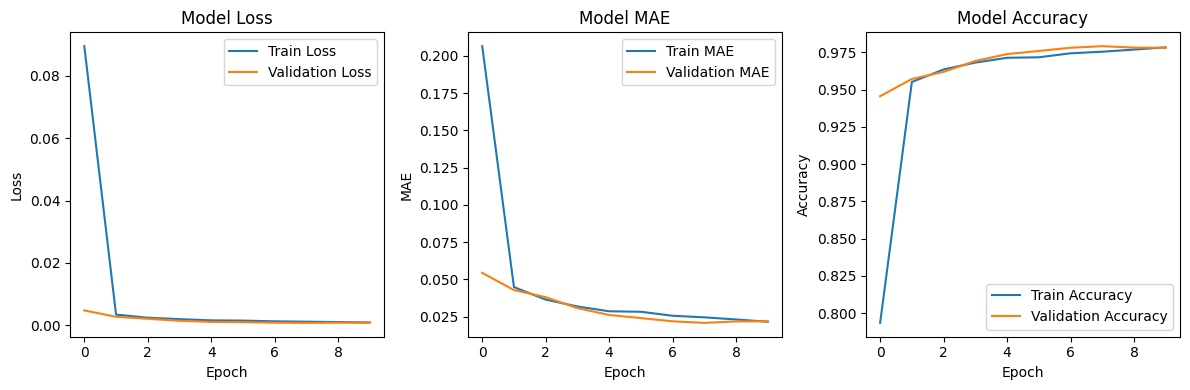

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(133)
plt.plot(1 - np.array(history.history['mae']), label='Train Accuracy')
plt.plot(1 - np.array(history.history['val_mae']), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_plots.png')
plt.show()


plot ril pred

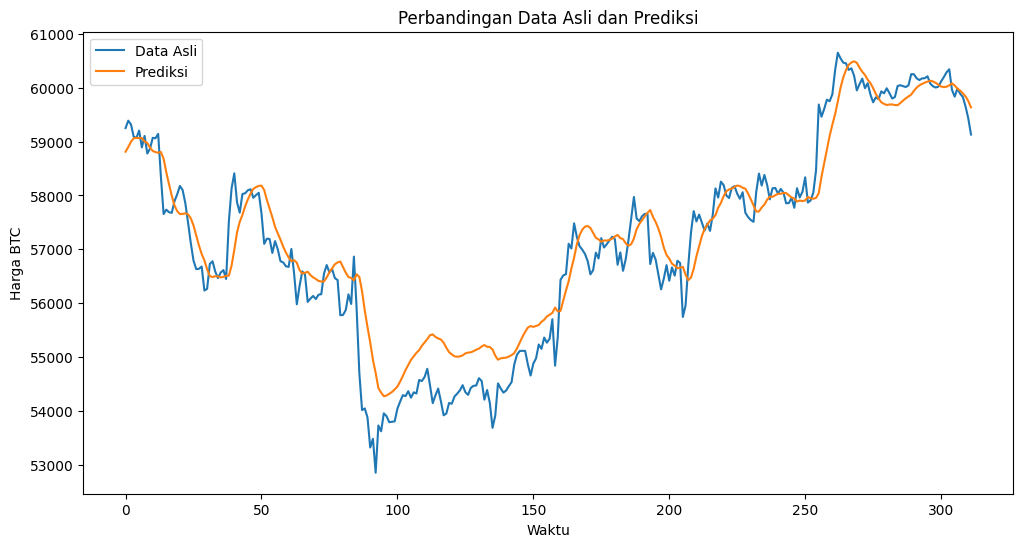

In [7]:
# Inverse transform untuk mendapatkan harga asli
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Data Asli')
plt.plot(y_pred_inv, label='Prediksi')
plt.title('Perbandingan Data Asli dan Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga BTC')
plt.legend()
plt.savefig('real_vs_predict.png')
plt.show()


pred

1/1 [==============================] - 0s 445ms/step


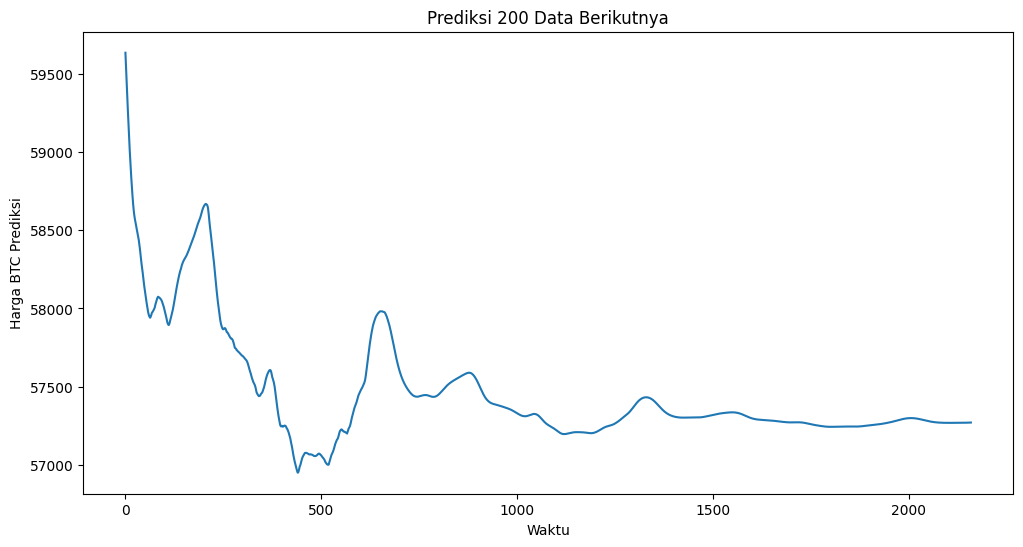

In [9]:
# Fungsi untuk prediksi beberapa langkah ke depan
def predict_future(model, last_sequence, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        prediction = model.predict(current_sequence.reshape(1, seq_length, 1))
        future_predictions.append(prediction[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = prediction
    
    return np.array(future_predictions)

# Prediksi 200 data berikutnya
last_sequence = X[-1]
future_predictions = predict_future(model, last_sequence, 30*24*3)

# Inverse transform untuk mendapatkan harga asli
future_predictions_inv = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Simpan prediksi ke CSV
future_df = pd.DataFrame(future_predictions_inv, columns=['Predicted_Price'])
future_df.to_csv('future_predictions.csv', index=False)

# Plot prediksi 200 data berikutnya
plt.figure(figsize=(12, 6))
plt.plot(future_predictions_inv)
plt.title('Prediksi 200 Data Berikutnya')
plt.xlabel('Waktu')
plt.ylabel('Harga BTC Prediksi')
plt.savefig('future_predictions_plot.png')
plt.show()